In [1]:
# Import packages
# DL Packages
import tensorflow as tf
import keras

# Others
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sympy as sym
import seaborn as sns

from sklearn.metrics import confusion_matrix

2023-11-29 13:13:24.652038: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 13:13:24.675509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 13:13:24.675533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 13:13:24.675547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 13:13:24.679782: I tensorflow/core/platform/cpu_feature_g

# Examine the Data:

I'll use the suggested IMDB movie review sentiment classification [dataset](https://keras.io/api/datasets/imdb/). This dataset has 25,000 movie reviews that are rated as either positive or negative. The data is pre-processed so that words have been replaced with positive integers that correspond to the frequency of a word. For example the 19th most common word will be represented as 19 + an offset we specify.

In [2]:
# Reading instructions from https://keras.io/api/datasets/imdb/
# With extra parameters specified

# Start of a sequence is marked as this
start_char = 1

# Words that are skipped because they are too infrequent are replaced by this
oov_char = 2

# Actual words have this index or higher
index_from = 3

# Skip the top n most common words
skip_top = 0

# Only the num_words most frequent words are kept.
# Anything less frequent is treated as oov
num_words = 20000

# Maximum length of the review. Truncate past this point
maxlen = 500

# Random seed to make loading deterministic
seed = 17

# Retrieve the training sequences.
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    start_char=start_char, oov_char=oov_char, index_from=index_from, seed=seed,
    skip_top=skip_top, num_words=num_words, maxlen=maxlen
)
# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()

# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)

# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"

# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])

print("x[0]", decoded_sequence)
print("y[0]", y_train[0])

x[0] [START] rudy does it again with this hot off the streets follow up to dolemite this entry is filled with the requisite rudy ray moore [OOV] humor and martial arts rudy [OOV] a crazy red neck sheriff in this movie that also features an infamous scene where rudy dives down a steep hill see it for laughs and for a brain blasting hit of blaxploitation magic
y[0] 1


In [3]:
np.unique(y_train)

array([0, 1])

This code looks like it gets the review text, and from this example it seems that y=1 is positive sentiment and y=0 is negative sentiment. Now let's make a function to load the data. For feeding it to our network we want to keep it in the integer encoding, but to examine the data we want the actual text.

In [4]:
def load_review(x_data: np.array, y_data: np.array, i: int, load_txt: bool = False, inverted_word_index:dict = inverted_word_index):
    """
    Loads the review at the specified index from the specified x, y data.

    Optionally converts to text.

    Args:
        x_data (np.array): dataset to load from (either x_train or x_test)
        y_data (np.array): labels to load from (either y_train or y_test)
        i (int): index of review to load
        load_txt (bool, optional): whether to convert integer encoding to text or not. Defaults to False.
        inverted_word_index (dict, optional): mapping of indices to words. Defaults to inverted_word_index.

    Returns:
        review_data, sentiment_label
    """

    review_data = x_data[i]

    if load_txt:
        review_data = " ".join(inverted_word_index[n] for n in x_train[i])

    return review_data, y_data[i]

Armed with this function, let's randomly select some positive and negative reviews to look at:

In [5]:
pos_idx = np.argwhere(y_train == 1).flatten()
neg_idx = np.argwhere(y_train == 0).flatten()

In [6]:
n_samples = 5

print("Positive Reviews...")
for n in range(n_samples):
    i = np.random.choice(pos_idx)
    print(load_review(x_train, y_train, i, load_txt=True))

print("\nNegative Reviews...")
for n in range(n_samples):
    i = np.random.choice(neg_idx)
    print(load_review(x_train, y_train, i, load_txt=True))


Positive Reviews...
("[START] barbra streisand is a tour de force in this hollywood story her performances and the songs are one of a kind and are special in the halls of great movies the scene where she is introduced to the [OOV] audience by [OOV] against the [OOV] wishes and hers only to turn them around with her magnificent performance of woman in the moon is one of the best examples on film of how well a great performer can win over an audience it's real the scene where she records evergreen ranks with the best in the business all live no lip sync very special streisand is often criticized for being a diva but she delivers on this one she is majestic singing with one more look at you she deserved the oscar she and paul williams got for evergreen [OOV] had his moments too far above most of his movie appearances this version of the born franchise ranks with the first one of 1937 janet [OOV] frederic march although i will always enjoy judy garland and james mason musical remake of 195

# Pre-Process Data:

For the assignment, I want to try two different approaches: the default frequency-based embeddings of the dataset, and using a GLOVE embedding to see if we're able to pick out more information. For the first one, we just need to get every entry to be the same length, but we need to do some work for the second one.

## Padding
Add Zeros up to max len and convert to numpy array

In [7]:
for i in range(len(x_train)):
    n_words = len(x_train[i])
    if n_words < maxlen:
        x_train[i] = x_train[i] + [0]*(maxlen-n_words)
    if isinstance(x_train[i], list):
        x_train[i] = np.array(x_train[i])
x_train = np.vstack(list(x_train))
y_train = y_train.reshape((-1, 1))

for i in range(len(x_test)):
    n_words = len(x_test[i])
    if n_words < maxlen:
        x_test[i] = x_test[i] + [0]*(maxlen-n_words)
    if isinstance(x_test[i], list):
        x_test[i] = np.array(x_test[i])
x_test = np.vstack(list(x_test))
y_test = y_test.reshape((-1, 1))

## Create GLOVE embedding

Followed the instructions from: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [8]:
import os
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [9]:
num_tokens = num_words + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < num_tokens:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 19132 words (69452 misses)


# Make/Train a Network

## RNN - Trained Embedding

In [10]:
# 20000 most common words, plus the out of dictionary
model = keras.Sequential([
    keras.layers.Embedding(input_dim=num_words+2, output_dim=100, mask_zero=True),
    keras.layers.SimpleRNN(64, return_sequences=False),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])
model.build()
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2014985 (7.69 MB)
Trainable params: 2014985 (7.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-11-29 13:13:31.490667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 13:13:31.493584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 13:13:31.493667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
history = model.fit(x_train, y_train, batch_size=12000, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50


2023-11-29 13:13:33.238038: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f92245cb8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 13:13:33.238063: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2023-11-29 13:13:33.241249: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-29 13:13:33.249214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-29 13:13:33.287083: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 3s 632ms/step - loss: 0.6950 - binary_accuracy: 0.5053 - val_loss: 0.6871 - val_binary_accuracy: 0.5500
Epoch 2/50
2/2 [==============================] - 1s 469ms/step - loss: 0.6723 - binary_accuracy: 0.6006 - val_loss: 0.6935 - val_binary_accuracy: 0.5163
Epoch 3/50
2/2 [==============================] - 1s 476ms/step - loss: 0.6889 - binary_accuracy: 0.5185 - val_loss: 0.6876 - val_binary_accuracy: 0.5283
Epoch 4/50
2/2 [==============================] - 1s 467ms/step - loss: 0.6718 - binary_accuracy: 0.5835 - val_loss: 0.6623 - val_binary_accuracy: 0.6115
Epoch 5/50
2/2 [==============================] - 1s 471ms/step - loss: 0.6483 - binary_accuracy: 0.6636 - val_loss: 0.7143 - val_binary_accuracy: 0.5948
Epoch 6/50
2/2 [==============================] - 1s 468ms/step - loss: 0.6771 - binary_accuracy: 0.6229 - val_loss: 0.6415 - val_binary_accuracy: 0.6572
Epoch 7/50
2/2 [==============================] - 1s 468ms/step - loss: 0.6027 - binary

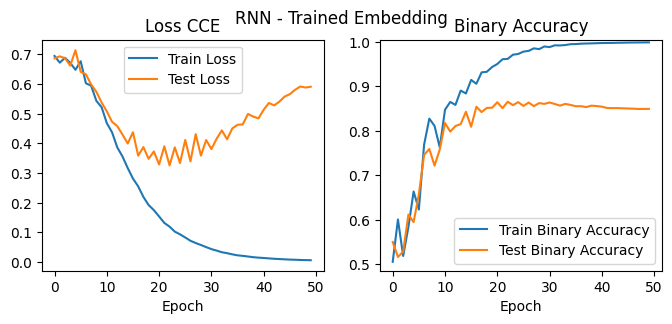

In [12]:
history_rnn = history
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
plt.suptitle("RNN - Trained Embedding")
ax[0].plot(history.history["loss"], label="Train Loss")
ax[0].set_title("Loss CCE")
ax[0].plot(history.history["val_loss"], label="Test Loss")
# ax[0].set_yscale("log")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history.history["binary_accuracy"], label="Train Binary Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Binary Accuracy")
ax[1].plot(history.history["val_binary_accuracy"], label="Test Binary Accuracy")
ax[1].set_ylim(min(history.history["binary_accuracy"])-0.02, 1.005)
ax[1].legend();

Although we were able to train to very high accuracy in our training set, it seems we were quite overfit, as the loss in our test set grew after about epoch 15.

## RNN - GLOVE Embedding

We're going to do the exact same network, only swapping the trained embeddings for a fixed GLOVE embedding.

In [13]:
# 20000 most common words, plus the out of dictionary
model = keras.Sequential([
    keras.layers.Embedding(input_dim=num_tokens, output_dim=embedding_dim,
                           mask_zero=True, embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                           trainable=False),
    keras.layers.SimpleRNN(64, return_sequences=False),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])
model.build()
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2000200   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2014985 (7.69 MB)
Trainable params: 14785 (57.75 KB)
Non-trainable params: 2000200 (7.63 MB)
_________________________________________________________________


In [14]:
history = model.fit(x_train, y_train, batch_size=12000, epochs=500, validation_data=(x_test, y_test))

Epoch 1/500
2/2 [==============================] - 2s 525ms/step - loss: 0.7184 - binary_accuracy: 0.5017 - val_loss: 0.7089 - val_binary_accuracy: 0.5055
Epoch 2/500
2/2 [==============================] - 1s 388ms/step - loss: 0.7082 - binary_accuracy: 0.5121 - val_loss: 0.6994 - val_binary_accuracy: 0.5107
Epoch 3/500
2/2 [==============================] - 1s 388ms/step - loss: 0.7015 - binary_accuracy: 0.5179 - val_loss: 0.6968 - val_binary_accuracy: 0.5234
Epoch 4/500
2/2 [==============================] - 1s 385ms/step - loss: 0.6978 - binary_accuracy: 0.5255 - val_loss: 0.6933 - val_binary_accuracy: 0.5281
Epoch 5/500
2/2 [==============================] - 1s 383ms/step - loss: 0.6922 - binary_accuracy: 0.5360 - val_loss: 0.6919 - val_binary_accuracy: 0.5281
Epoch 6/500
2/2 [==============================] - 1s 388ms/step - loss: 0.6911 - binary_accuracy: 0.5370 - val_loss: 0.6905 - val_binary_accuracy: 0.5315
Epoch 7/500
2/2 [==============================] - 1s 388ms/step - los

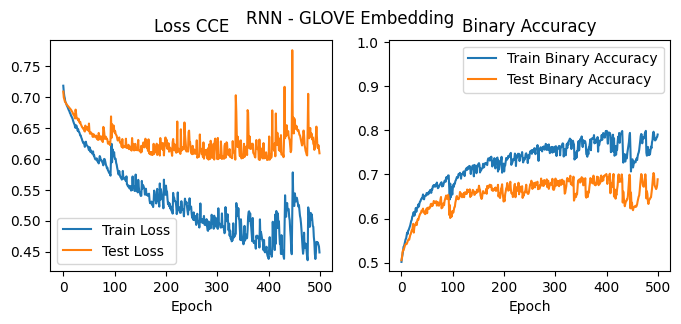

In [15]:
history_rnn_g = history
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
plt.suptitle("RNN - GLOVE Embedding")
ax[0].plot(history.history["loss"], label="Train Loss")
ax[0].set_title("Loss CCE")
ax[0].plot(history.history["val_loss"], label="Test Loss")
# ax[0].set_yscale("log")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history.history["binary_accuracy"], label="Train Binary Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Binary Accuracy")
ax[1].plot(history.history["val_binary_accuracy"], label="Test Binary Accuracy")
ax[1].set_ylim(min(history.history["binary_accuracy"])-0.02, 1.005)
ax[1].legend();

Interestingly the GLOVE embedding seems to lead to slower training and worse performance, it's possible I'm not setting up the embedding right, or some other structure would be more appropriate here.

## LSTM -- Trained Embedding

In [16]:
# 20000 most common words, plus the out of dictionary
model = keras.Sequential([
    keras.layers.Embedding(input_dim=num_words+2, output_dim=100, mask_zero=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])
model.build()
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2000200   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2046665 (7.81 MB)
Trainable params: 2046665 (7.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
history = model.fit(x_train, y_train, batch_size=5000, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50


2023-11-29 13:19:19.434833: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'


5/5 [==============================] - 4s 350ms/step - loss: 0.6923 - binary_accuracy: 0.5489 - val_loss: 0.6902 - val_binary_accuracy: 0.5974
Epoch 2/50
5/5 [==============================] - 1s 201ms/step - loss: 0.6869 - binary_accuracy: 0.6256 - val_loss: 0.6819 - val_binary_accuracy: 0.6596
Epoch 3/50
5/5 [==============================] - 1s 222ms/step - loss: 0.6723 - binary_accuracy: 0.7032 - val_loss: 0.6591 - val_binary_accuracy: 0.7052
Epoch 4/50
5/5 [==============================] - 1s 222ms/step - loss: 0.6295 - binary_accuracy: 0.7554 - val_loss: 0.5635 - val_binary_accuracy: 0.7756
Epoch 5/50
5/5 [==============================] - 1s 214ms/step - loss: 0.5008 - binary_accuracy: 0.7810 - val_loss: 0.4627 - val_binary_accuracy: 0.8001
Epoch 6/50
5/5 [==============================] - 1s 222ms/step - loss: 0.4056 - binary_accuracy: 0.8470 - val_loss: 0.3905 - val_binary_accuracy: 0.8387
Epoch 7/50
5/5 [==============================] - 1s 223ms/step - loss: 0.3168 - binary

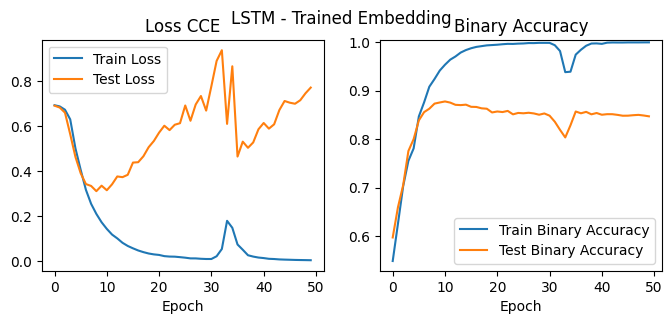

In [18]:
history_lstm = history
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
plt.suptitle("LSTM - Trained Embedding")
ax[0].plot(history.history["loss"], label="Train Loss")
ax[0].set_title("Loss CCE")
ax[0].plot(history.history["val_loss"], label="Test Loss")
# ax[0].set_yscale("log")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history.history["binary_accuracy"], label="Train Binary Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Binary Accuracy")
ax[1].plot(history.history["val_binary_accuracy"], label="Test Binary Accuracy")
ax[1].set_ylim(min(history.history["binary_accuracy"])-0.02, 1.005)
ax[1].legend();

It's a similar story to the RNN where we're clearly overfit. It does seem like minus the one weird spike, the training is smoother with the LSTM.

## LSTM -- GLOVE Embedding

In [19]:
# 20000 most common words, plus the out of dictionary
model = keras.Sequential([
    keras.layers.Embedding(input_dim=num_tokens, output_dim=embedding_dim,
                           mask_zero=True, embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                           trainable=False),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])
model.build()
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         2000200   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2046665 (7.81 MB)
Trainable params: 46465 (181.50 KB)
Non-trainable params: 2000200 (7.63 MB)
_________________________________________________________________


In [20]:
history = model.fit(x_train, y_train, batch_size=5000, epochs=500, validation_data=(x_test, y_test))

Epoch 1/500


5/5 [==============================] - 3s 307ms/step - loss: 0.6944 - binary_accuracy: 0.5092 - val_loss: 0.6914 - val_binary_accuracy: 0.5253
Epoch 2/500
5/5 [==============================] - 1s 165ms/step - loss: 0.6912 - binary_accuracy: 0.5256 - val_loss: 0.6890 - val_binary_accuracy: 0.5462
Epoch 3/500
5/5 [==============================] - 1s 166ms/step - loss: 0.6886 - binary_accuracy: 0.5409 - val_loss: 0.6866 - val_binary_accuracy: 0.5551
Epoch 4/500
5/5 [==============================] - 1s 165ms/step - loss: 0.6852 - binary_accuracy: 0.5564 - val_loss: 0.6836 - val_binary_accuracy: 0.5593
Epoch 5/500
5/5 [==============================] - 1s 165ms/step - loss: 0.6806 - binary_accuracy: 0.5659 - val_loss: 0.6791 - val_binary_accuracy: 0.5641
Epoch 6/500
5/5 [==============================] - 1s 165ms/step - loss: 0.6747 - binary_accuracy: 0.5778 - val_loss: 0.6729 - val_binary_accuracy: 0.5800
Epoch 7/500
5/5 [==============================] - 1s 165ms/step - loss: 0.6717 - 

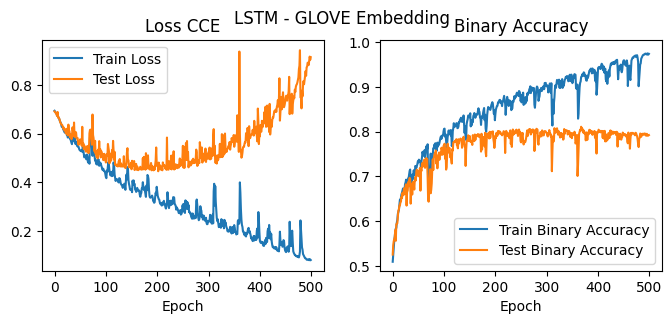

In [21]:
history_lstm_g = history
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
plt.suptitle("LSTM - GLOVE Embedding")
ax[0].plot(history.history["loss"], label="Train Loss")
ax[0].set_title("Loss CCE")
ax[0].plot(history.history["val_loss"], label="Test Loss")
# ax[0].set_yscale("log")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history.history["binary_accuracy"], label="Train Binary Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Binary Accuracy")
ax[1].plot(history.history["val_binary_accuracy"], label="Test Binary Accuracy")
ax[1].set_ylim(min(history.history["binary_accuracy"])-0.02, 1.005)
ax[1].legend();

The LSTM seems to do a better job with the GLOVE embeddings, but it still doesn't seem to do too well. Maybe a different architecture would be good for this?

## Summary Results

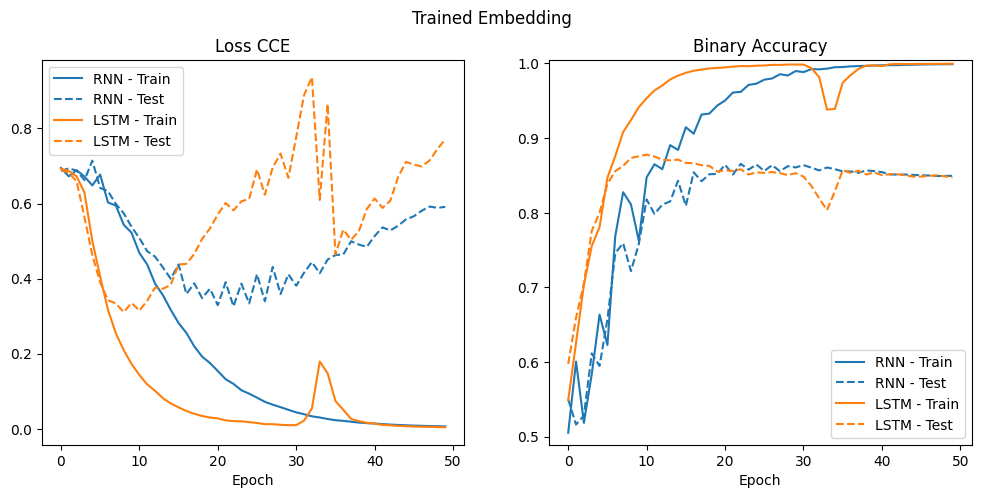

In [35]:
f, ax = plt.subplots(ncols=2)
f.set_size_inches(12,5)
plt.suptitle("Trained Embedding")
ax[0].plot(history_rnn.history["loss"], label="RNN - Train", color="tab:blue")
ax[0].plot(history_rnn.history["val_loss"], label="RNN - Test", ls="dashed", color="tab:blue")
ax[0].plot(history_lstm.history["loss"], label="LSTM - Train", color="tab:orange")
ax[0].plot(history_lstm.history["val_loss"], label="LSTM - Test", ls="dashed", color="tab:orange")
ax[0].set_title("Loss CCE")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history_rnn.history["binary_accuracy"], label="RNN - Train", color="tab:blue")
ax[1].plot(history_rnn.history["val_binary_accuracy"], label="RNN - Test", ls="dashed", color="tab:blue")
ax[1].plot(history_lstm.history["binary_accuracy"], label="LSTM - Train", color="tab:orange")
ax[1].plot(history_lstm.history["val_binary_accuracy"], label="LSTM - Test", ls="dashed", color="tab:orange")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Binary Accuracy")
ax[1].set_ylim(min(history.history["binary_accuracy"])-0.02, 1.005)
ax[1].legend();

The LSTM appears to train significantly faster than the RNN, and it reaches a lower overall loss and higher accuracy on the test data than the RNN.

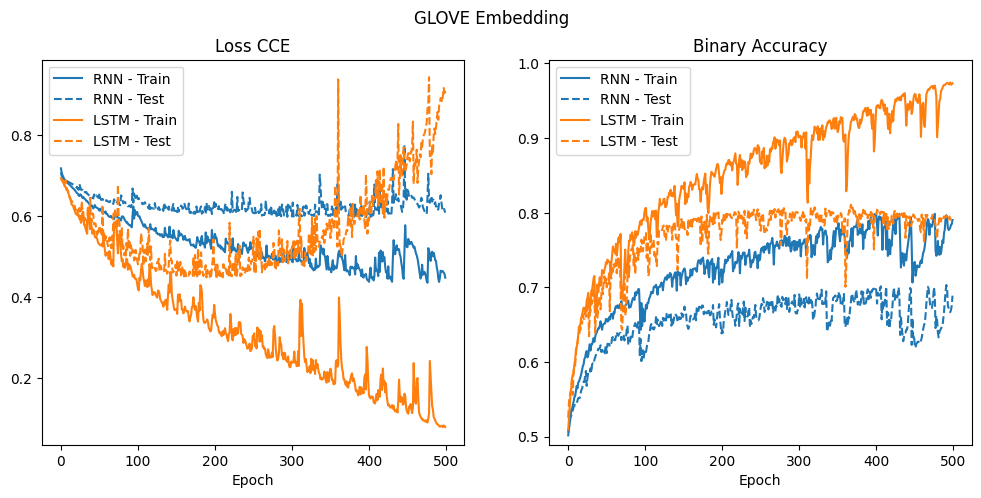

In [36]:
f, ax = plt.subplots(ncols=2)
f.set_size_inches(12,5)
plt.suptitle("GLOVE Embedding")
ax[0].plot(history_rnn_g.history["loss"], label="RNN - Train", color="tab:blue")
ax[0].plot(history_rnn_g.history["val_loss"], label="RNN - Test", ls="dashed", color="tab:blue")
ax[0].plot(history_lstm_g.history["loss"], label="LSTM - Train", color="tab:orange")
ax[0].plot(history_lstm_g.history["val_loss"], label="LSTM - Test", ls="dashed", color="tab:orange")
ax[0].set_title("Loss CCE")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history_rnn_g.history["binary_accuracy"], label="RNN - Train", color="tab:blue")
ax[1].plot(history_rnn_g.history["val_binary_accuracy"], label="RNN - Test", ls="dashed", color="tab:blue")
ax[1].plot(history_lstm_g.history["binary_accuracy"], label="LSTM - Train", color="tab:orange")
ax[1].plot(history_lstm_g.history["val_binary_accuracy"], label="LSTM - Test", ls="dashed", color="tab:orange")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Binary Accuracy")
ax[1].set_ylim(min(history.history["binary_accuracy"])-0.02, 1.005)
ax[1].legend();

The LSTM definitely appears to be doing more with the GLOVE embedding than the RNN is, but both seem to be doing a pretty poor job overall. Either I'm doing something wrong with the embedding, or a different network structure would be more appropriate here.